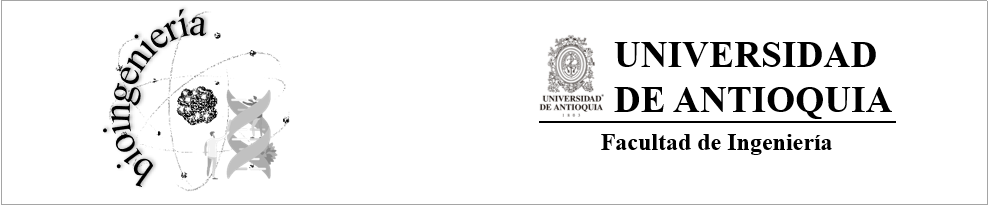

# Redes Neuronales Recurrentes - Recurrent Neural Networks (RNN)

Permite hacer procesamiento de datos que tienen naturaleza secuencial, es decir, la secuencia de los datos es muy importante para este problema. Por ejemplo:

1. Un programa que clasifica videos: No importa el fotograma en particula, sino toda la secuencia de estos.
2. Series de tiempo como el clima. Para predecir el clima, es necesario saber que pasó en los días anteriores.
3. Procesamiento de audio.
4. Traductores de texto.
5. Procesamiento de lenguaje natural.

Para este último caso, el orden en que se diga una oración es importante para dar a entender una idea y también depende del orden las pabras puede tener un significado diferente según el contexto en el que se encuentre.

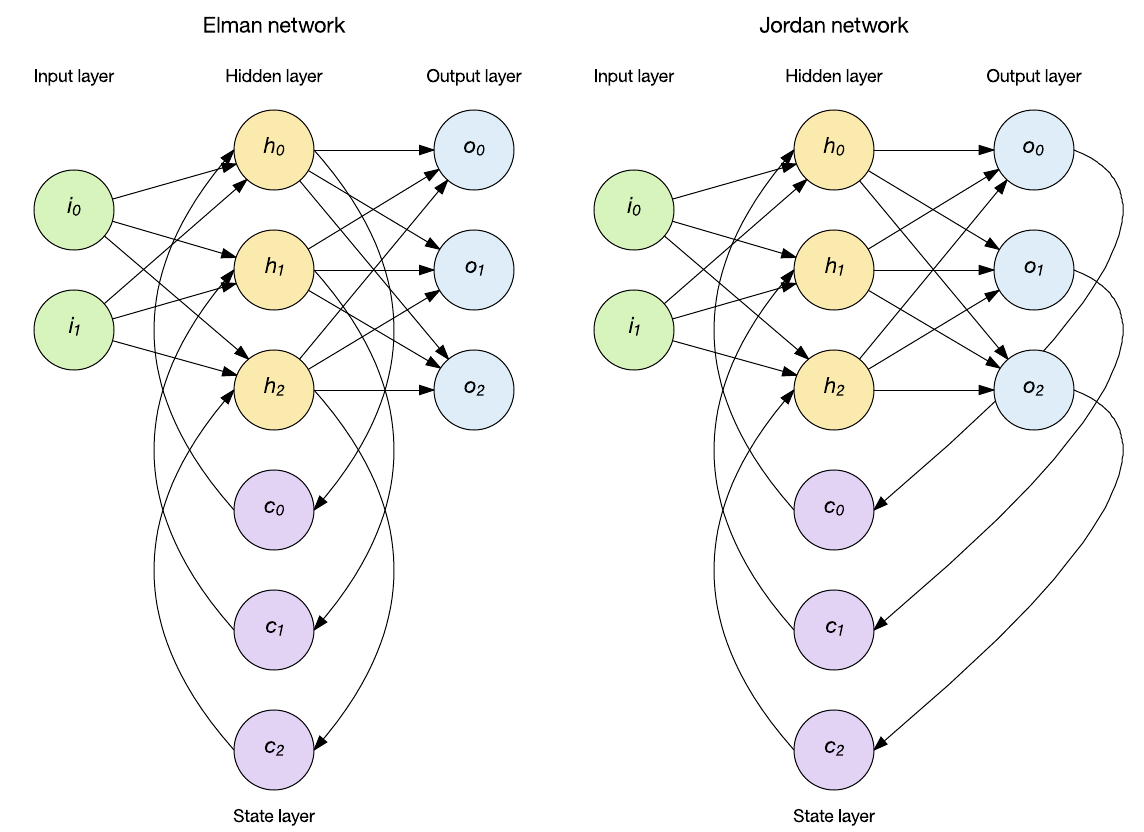

Otra forma de poder ilustrar la RNN puede ser

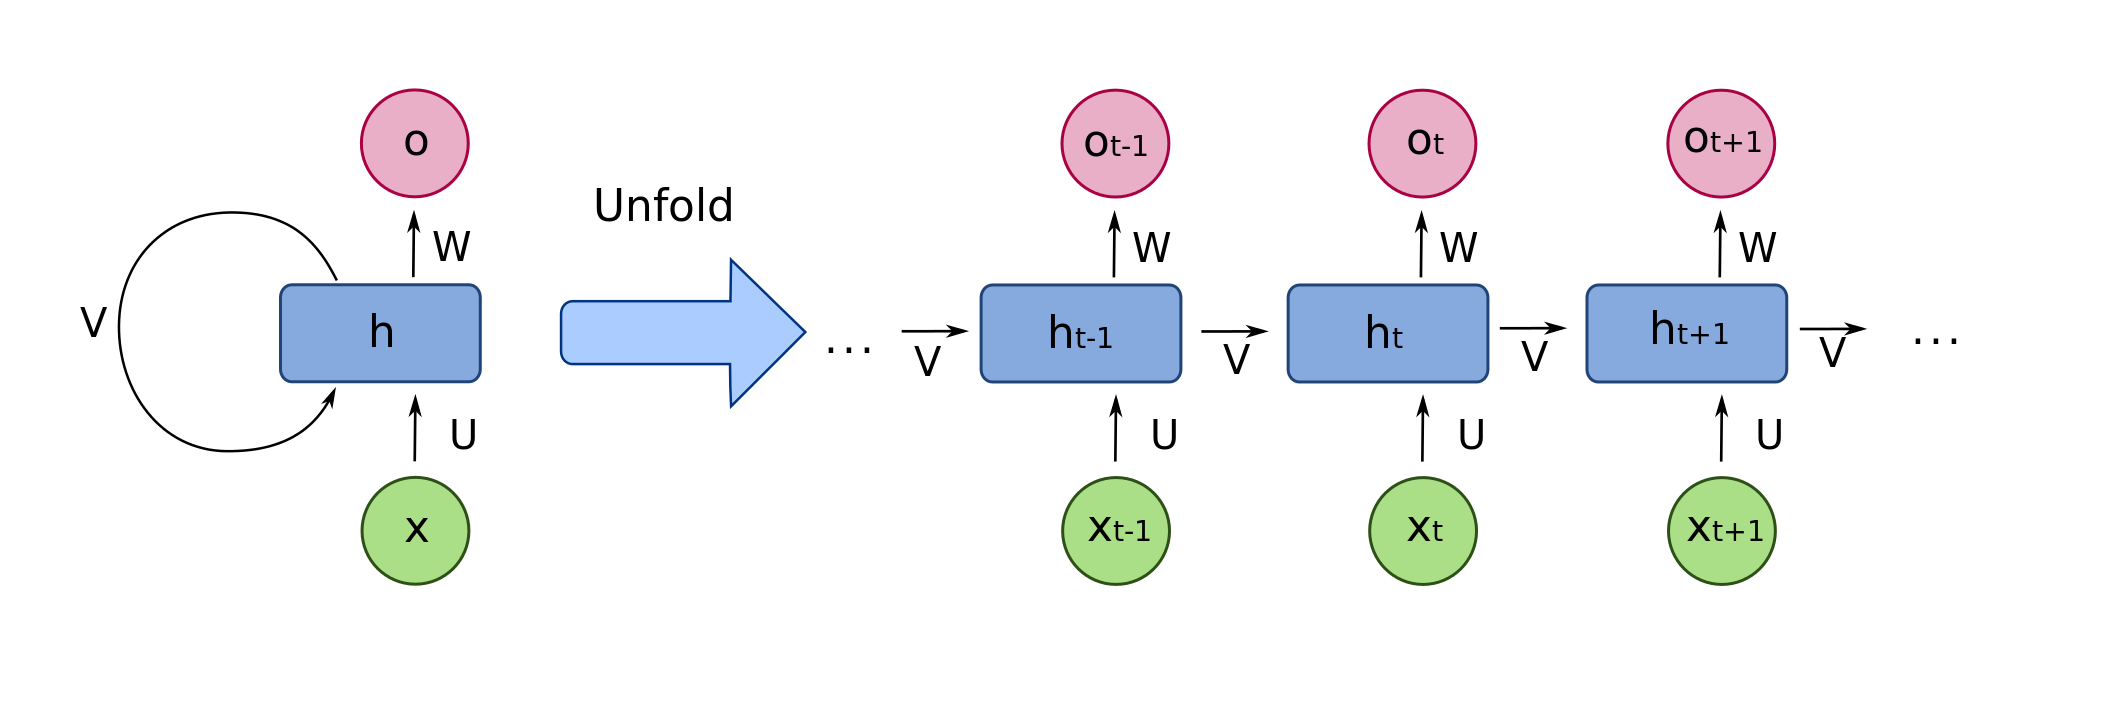

## Ejemplos de diferentes arquitecturas

### 1. Image Captioning
Donde la entrada es una imagen y la salida es una secuencia de palabras (varias) que describen la imagen


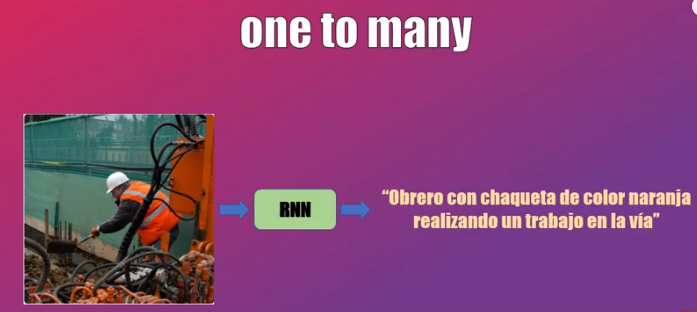

### 2. Análisis de sentimiento
Donde la entrada es un párrafo y la salida es una clasificación. Por ejemplo, la entradas es una crítica a una película y la salida es si la palícula le gustó o no a la persona.


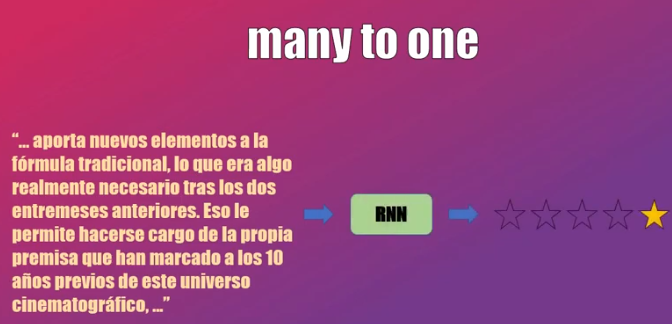

### 3. Traductures de texto
Donde tanto a la entrada como a la salida es una secuencia. Por ejemplo, para este caso la salida no se puede generar uno a uno, se debe tener toda la frase para poder hacer una traducción más acertada.


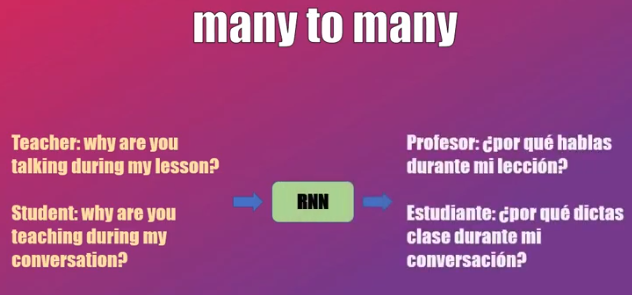

Otro ejemplo pueden ser los conversores de voz a texto o texto a voz

# Experimentación

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
#split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps
		if end_ix > len(sequence)-1:
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

def create_datasetMultipleTimesBackAhead(dataset, n_steps_out=1, n_steps_in = 1, overlap = 1):
	dataX, dataY = [], []
	tem = n_steps_in + n_steps_out - overlap
	for i in range(int((len(dataset) - tem)/overlap)):
		startx = i*overlap
		endx = startx + n_steps_in
		starty = endx
		endy = endx + n_steps_out
		a = dataset[startx:endx, 0]
		dataX.append(a)
		dataY.append(dataset[starty:endy, 0])
	return np.array(dataX), np.array(dataY)

def PintaResultado(dataset,trainPredict,testPredict,look_back):
	trainPredictPlot = np.empty_like(dataset)
	trainPredictPlot[:, :] = np.nan
	trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
	# shift test predictions for plotting
	testPredictPlot = np.empty_like(dataset+1)
	testPredictPlot[:, :] = np.nan
	testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict
	#testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
	#testPredictPlot[len(dataset)-len(testPredict):len(dataset)+1, :] = testPredict
	# plot baseline and predictions
	plt.plot(dataset,label='Original Time serie')
	plt.plot(trainPredictPlot,label='Training prediction')
	plt.plot(testPredictPlot,label='Test prediction')
	plt.legend()
	plt.show()


def EstimaRMSE(model,X_train,X_test,y_train,y_test,scaler,look_back):
	# make predictions
	trainPredict = model.predict(X_train.reshape(X_train.shape[0],look_back))
	testPredict = model.predict(X_test.reshape(X_test.shape[0],look_back))
	# invert predictions
	trainPredict = scaler.inverse_transform(trainPredict)
	trainY = scaler.inverse_transform([y_train.flatten()])
	testPredict = scaler.inverse_transform(testPredict)
	testY = scaler.inverse_transform([y_test.flatten()])
	# calculate root mean squared error
	trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
	print('Train Score: %.2f RMSE' % (trainScore))
	testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
	print('Test Score: %.2f RMSE' % (testScore))
	return trainPredict, testPredict

def EstimaRMSE_RNN(model,X_train,X_test,y_train,y_test,scaler,look_back,n_steps):
	# make predictions
	trainPredict = model.predict(X_train.reshape(X_train.shape[0],n_steps,look_back))
	testPredict = model.predict(X_test.reshape(X_test.shape[0],n_steps,look_back))
	# invert predictions
	trainPredict = scaler.inverse_transform(trainPredict)
	trainY = scaler.inverse_transform([y_train.flatten()])
	testPredict = scaler.inverse_transform(testPredict)
	testY = scaler.inverse_transform([y_test.flatten()])
	# calculate root mean squared error
	trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
	print('Train Score: %.2f RMSE' % (trainScore))
	testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
	print('Test Score: %.2f RMSE' % (testScore))
	return trainPredict, testPredict

def EstimaRMSE_MultiStep(model,X_train,X_test,y_train,y_test,scaler,look_back,n_steps):
	# make predictions
	trainPredict = model.predict(X_train.reshape(X_train.shape[0],look_back))
	testPredict = []
	for i in range(X_test.shape[0]):
		temPredict = np.zeros([n_steps])
		for j in range(n_steps):
			if j==0:
				xtest = X_test[i,:]
			else:
				xtest = np.concatenate((X_test[i,j:],temPredict[:j]))
			temPredict[j] = model.predict(xtest.reshape(1,look_back))
		testPredict.append(temPredict)
	testPredict = np.array(testPredict)
	testPredict = testPredict.flatten()
	# invert predictions
	trainPredict = scaler.inverse_transform(trainPredict)
	trainY = scaler.inverse_transform([y_train.flatten()])
	testPredict = scaler.inverse_transform(testPredict.reshape(-1, 1))
	testY = scaler.inverse_transform([y_test.flatten()])
	# calculate root mean squared error
	trainScore = math.sqrt(mean_squared_error(trainY.reshape(-1, 1), trainPredict.reshape(-1, 1)))
	print('Train Score: %.2f RMSE' % (trainScore))
	testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
	print('Test Score: %.2f RMSE' % (testScore))
	return trainPredict, testPredict

def EstimaRMSE_MultiOuput(model,X_train,X_test,y_train,y_test,scaler,look_back):
	# make predictions
	trainPredict = model.predict(X_train.reshape(X_train.shape[0],look_back))
	testPredict = model.predict(X_test.reshape(X_test.shape[0],look_back))
	# invert predictions
	trainPredict = scaler.inverse_transform(trainPredict.flatten().reshape(-1, 1))
	trainY = scaler.inverse_transform([y_train.flatten()])
	testPredict = scaler.inverse_transform(testPredict.flatten().reshape(-1, 1))
	testY = scaler.inverse_transform([y_test.flatten()])
	# calculate root mean squared error
	trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
	print('Train Score: %.2f RMSE' % (trainScore))
	testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
	print('Test Score: %.2f RMSE' % (testScore))
	return trainPredict, testPredict

def EstimaRMSE_RNN_MultiStep(model,X_train,X_test,y_train,y_test,scaler,look_back,n_steps,flag):
	# make predictions
	if flag == 1:#multiple times set as features
		trainPredict = model.predict(X_train.reshape(X_train.shape[0],1,look_back))
		testPredict = []
		for i in range(X_test.shape[0]):
			temPredict = np.zeros([n_steps])
			for j in range(n_steps):
				if j==0:
					xtest = X_test[i,:]
				else:
					xtest = np.concatenate((X_test[i,j:],temPredict[:j]))
				temPredict[j] = model.predict(xtest.reshape(1,1,look_back))
			testPredict.append(temPredict)
		testPredict = np.array(testPredict)
		testPredict = testPredict.flatten()
	else: #multiple times set as times
		trainPredict = model.predict(X_train.reshape(X_train.shape[0],look_back,1))
		testPredict = []
		for i in range(X_test.shape[0]):
			temPredict = np.zeros([n_steps])
			for j in range(n_steps):
				if j==0:
					xtest = X_test[i,:]
				else:
					xtest = np.concatenate((X_test[i,j:],temPredict[:j]))
				temPredict[j] = model.predict(xtest.reshape(1,look_back,1))
			testPredict.append(temPredict)
		testPredict = np.array(testPredict)
		testPredict = testPredict.flatten()

	# invert predictions
	trainPredict = scaler.inverse_transform(trainPredict.reshape(-1, 1))
	trainY = scaler.inverse_transform(y_train)
	testPredict = scaler.inverse_transform(testPredict.reshape(-1, 1))
	testY = scaler.inverse_transform(y_test.flatten().reshape(-1, 1))
	# calculate root mean squared error
	trainScore = math.sqrt(mean_squared_error(trainY.reshape(-1, 1), trainPredict.reshape(-1, 1)))
	print('Train Score: %.2f RMSE' % (trainScore))
	testScore = math.sqrt(mean_squared_error(testY.reshape(-1, 1), testPredict.reshape(-1, 1)))
	print('Test Score: %.2f RMSE' % (testScore))
	return trainPredict, testPredict

def EstimaRMSE_RNN_MultiStepEncoDeco(model,X_train,X_test,y_train,y_test,scaler,look_back,n_steps):
	# make predictions
	trainPredict = model.predict(X_train.reshape(X_train.shape[0],look_back,1))
	trainPredict = trainPredict.flatten()
	testPredict = model.predict(X_test.reshape(X_test.shape[0],look_back,1))
	testPredict = testPredict.flatten()
	# invert predictions
	trainPredict = scaler.inverse_transform(trainPredict.reshape(-1, 1))
	trainY = scaler.inverse_transform(y_train.flatten().reshape(-1, 1))
	testPredict = scaler.inverse_transform(testPredict.reshape(-1, 1))
	testY = scaler.inverse_transform(y_test.flatten().reshape(-1, 1))
	# calculate root mean squared error
	trainScore = math.sqrt(mean_squared_error(trainY.flatten().reshape(-1, 1), trainPredict.reshape(-1, 1)))
	print('Train Score: %.2f RMSE' % (trainScore))
	testScore = math.sqrt(mean_squared_error(testY.flatten().reshape(-1, 1), testPredict.reshape(-1, 1)))
	print('Test Score: %.2f RMSE' % (testScore))
	return trainPredict, testPredict

## Usaremos una ANN (MLP) para hacer la predicción

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# https://github.com/angelower/infomed20251/blob/main/data/international-airline-passengers.csv
# !wget https://raw.githubusercontent.com/angelower/infomed20251/main/data/international-airline-passengers.csv

--2025-05-27 12:28:04--  https://raw.githubusercontent.com/angelower/infomed20251/main/data/international-airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1894 (1.8K) [text/plain]
Saving to: ‘international-airline-passengers.csv’

international-airli 100%[===================>]   1.85K  --.-KB/s    in 0.01s   

2025-05-27 12:28:04 (185 KB/s) - ‘international-airline-passengers.csv’ saved [1894/1894]



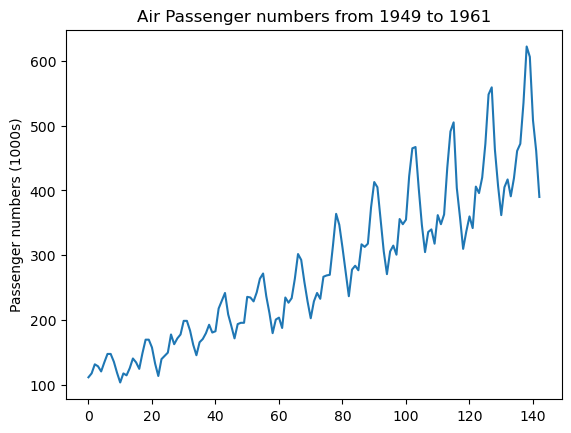

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

datasetO = pd.read_csv("international-airline-passengers.csv", usecols=[1], engine='python', skipfooter=3)
plt.plot(datasetO.astype('float32'))
plt.ylabel('Passenger numbers (1000s)')
plt.title('Air Passenger numbers from 1949 to 1961')
plt.show()

In [4]:
from sklearn.preprocessing import MinMaxScaler
look_back=1
dataset = datasetO.values
dataset = dataset.astype('float32')

# Se divide el conjunto de datos en train and test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset)]

# Se normaliza el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
trainN = scaler.fit_transform(train)
testN = scaler.transform(test)
X_train, y_train = split_sequence(trainN, look_back)
X_test, y_test = split_sequence(testN, look_back)

In [5]:
print('Train',X_train[:10])
print('Test',y_train[:10])

Train [[[0.02588999]]

 [[0.04530746]]

 [[0.09061491]]

 [[0.08090615]]

 [[0.05501619]]

 [[0.10032365]]

 [[0.14239484]]

 [[0.14239484]]

 [[0.10355988]]

 [[0.04854369]]]
Test [[0.04530746]
 [0.09061491]
 [0.08090615]
 [0.05501619]
 [0.10032365]
 [0.14239484]
 [0.14239484]
 [0.10355988]
 [0.04854369]
 [0.        ]]


In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from tensorflow import keras

In [7]:
model1 = Sequential()
model1.add(Dense(5,activation = 'relu',input_dim=1))
model1.add(Dense(1))
model1.summary()

/opt/anaconda3/envs/ML/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-27 12:29:07.924014: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-05-27 12:29:07.924091: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-27 12:29:07.924098: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-27 12:29:07.924301: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-27 12:29:07.924324: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 5)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16 (64.00 B)

 Trainable params: 16 (64.00 B)

 Non-trainable params: 0 (0.00 B)

2025-05-27 12:29:26.241750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Train Score: 47.89 RMSE
Test Score: 136.54 RMSE


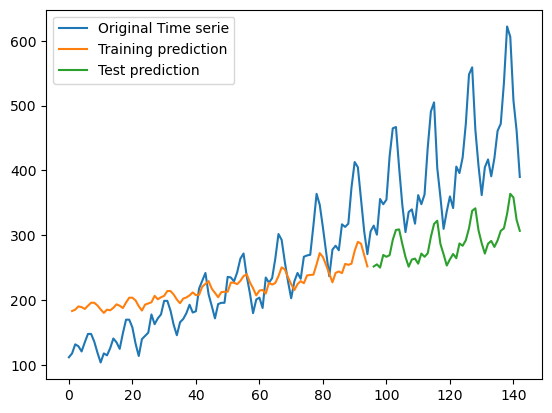

In [8]:
model1.compile(optimizer='adam',loss='mse')
model1.fit(X_train.reshape(X_train.shape[0],look_back),y_train.flatten(),epochs=200, verbose=0)
trainPredict, testPredict = EstimaRMSE(model1,X_train,X_test,y_train,y_test,scaler,look_back)
PintaResultado(dataset,trainPredict,testPredict,look_back)

Usar dos pasos hacia atrás para predecir un paso adelante:

/opt/anaconda3/envs/ML/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Train Score: 28.45 RMSE
Test Score: 61.68 RMSE


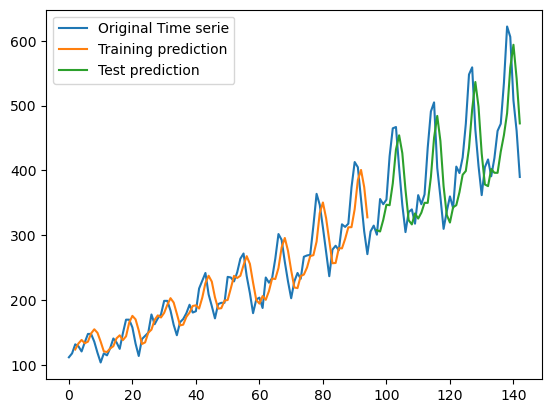

In [9]:
look_back = 2;
X_train, y_train = split_sequence(trainN, look_back)
X_test, y_test = split_sequence(testN, look_back)
#keras.backend.clear_session()
model2 = Sequential()
model2.add(Dense(5,activation = 'relu',input_dim=look_back))
model2.add(Dense(1))
model2.compile(optimizer='adam',loss='mse')
model2.fit(X_train.reshape(X_train.shape[0],look_back),y_train.reshape(X_train.shape[0],1),epochs=200, verbose=0)
trainPredict, testPredict = EstimaRMSE(model2,X_train,X_test,y_train,y_test,scaler,look_back)
PintaResultado(dataset,trainPredict,testPredict,look_back)

In [10]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 5)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65 (264.00 B)

 Trainable params: 21 (84.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 44 (180.00 B)

Usar tres pasos hacia atrás para predecir un paso adelante:

/opt/anaconda3/envs/ML/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x3126d8280> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Train Score: 79.82 RMSE
Test Score: 200.49 RMSE


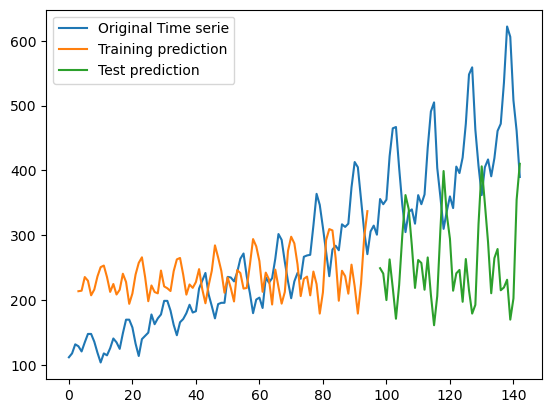

In [11]:
look_back = 3;
X_train, y_train = split_sequence(trainN, look_back)
X_test, y_test = split_sequence(testN, look_back)
model3 = Sequential()
model3.add(Dense(5,activation = 'relu',input_dim=look_back))
model3.add(Dense(1))
model3.compile(optimizer='adam',loss='mse')
model3.fit(X_train.reshape(X_train.shape[0],look_back),y_train.flatten(),epochs=200, verbose=0)
trainPredict, testPredict = EstimaRMSE(model3,X_train,X_test,y_train,y_test,scaler,look_back)
PintaResultado(dataset,trainPredict,testPredict,look_back)

In [12]:
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 5)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80 (324.00 B)

 Trainable params: 26 (104.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 54 (220.00 B)


# Usemos ahora una capa de una RNN en lugar de una densa:

La entrada de los datos debe tener la siguiente estructura: [n_samples,n_times,n_features]

Input: <b>[n_samples,1,1]</b>


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Train Score: 22.90 RMSE
Test Score: 52.97 RMSE


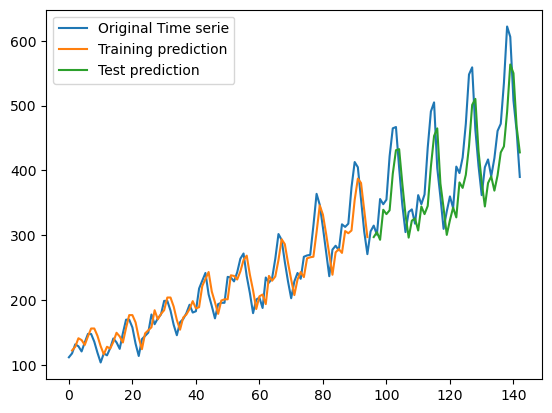

In [13]:
from keras.layers import Input

look_back = 1;
X_train, y_train = create_dataset(trainN, look_back)
X_test, y_test = create_dataset(testN, look_back)
model4 = Sequential()
model4.add(Input((1,look_back)))
model4.add(SimpleRNN(5,activation = 'relu'))
model4.add(Dense(1))
model4.compile(optimizer='adam',loss='mse')
model4.fit(X_train.reshape(X_train.shape[0],1,look_back),y_train.flatten(),epochs=500, verbose=0)
trainPredict, testPredict = EstimaRMSE_RNN(model4,X_train,X_test,y_train,y_test,scaler,look_back,1)
PintaResultado(dataset,trainPredict,testPredict,look_back)

In [14]:
model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 5)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125 (504.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 84 (340.00 B)

# Usar varias veces como características

Input: <b>[n_samples,1,2]</b>

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Train Score: 25.03 RMSE
Test Score: 54.69 RMSE


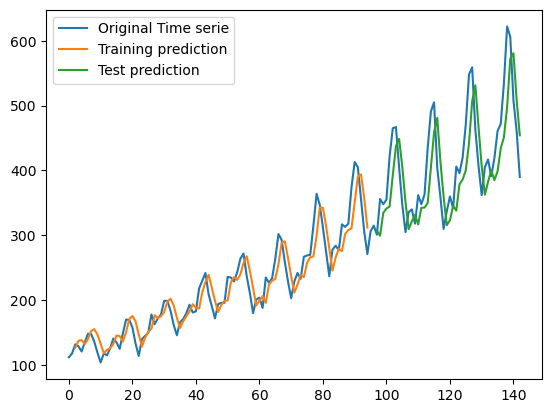

In [15]:
look_back = 2;
X_train, y_train = create_dataset(trainN, look_back)
X_test, y_test = create_dataset(testN, look_back)
model4b = Sequential()
model4b.add(Input((1,look_back)))
model4b.add(SimpleRNN(5,activation = 'relu'))
model4b.add(Dense(1))
model4b.compile(optimizer='adam',loss='mse')
model4b.fit(X_train.reshape(X_train.shape[0],1,look_back),y_train.flatten(),epochs=500, verbose=0)
trainPredict, testPredict = EstimaRMSE_RNN(model4b,X_train,X_test,y_train,y_test,scaler,look_back,1)
PintaResultado(dataset,trainPredict,testPredict,look_back)

In [16]:
model4b.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 5)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140 (564.00 B)

 Trainable params: 46 (184.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 94 (380.00 B)